In [1]:
# 这个文件用来处理数据
# 导入必要的库
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
import pyarrow
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from sklearn.preprocessing import LabelEncoder # label encoding

In [2]:
# 这里需要处理所有6类数据

def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
         
        '''   
        if col[-1] in ("L, M, T"):
            # 如果类型是布尔值，不变
            # 否则，改名col + "_string"
            if df[col].dtype != pl.Boolean:
                df = df.with_columns(pl.col(col).alias(col + "_string"))
        '''        
            
        # 处理D(日期) 转为时间戳
        if col[-1] == 'D':
            # 0 if null, otherwise timestamp.  
            df = df.with_columns(
                pl.when(pl.col(col).is_null())
                    .then(pl.lit(0))
                    .otherwise(pl.col(col).str.to_date( ).dt.timestamp())
                    .alias(col)
            )
            #print(df[col])

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    #label_encoder = LabelEncoder() # 使用标签编码？似乎不使用效果更好
    
    for col in df.columns:  
        if df[col].dtype.name == 'bool':
            continue
        if (df[col].dtype.name in ['object', 'string']) or (col[-1] in ("L", "M", "T")):
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
            
            #df[col] = label_encoder.fit_transform(df[col])
            
            
    return df

def remove_letters(text):
    text = str(text)
    return int("".join(filter(str.isdigit, text)))

def employment_length(text):
    text = str(text)
    if text == "LESS_ONE":
        return 1
    if text == "MORE_ONE":
        return 2
    if text == "MORE_FIVE":
        return 3
    return 0
    

In [3]:
# 提交的时候要用到这个base_folder
base_folder = "/kaggle/input/home-credit-credit-risk-model-stability/csv_files/"
#  先考虑训练集

# base
train_basetable = pl.read_csv("train/train_base.csv")

# static
train_static = pl.concat(
    [
        pl.read_csv("train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv("train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)

# static_cb
train_static_cb = pl.read_csv("train/train_static_cb_0.csv").pipe(set_table_dtypes)

# person 这里添加了新文件；数字对应depth
# 例：person1 depth=1; person2 depth=2
train_person_1 = pl.read_csv("train/train_person_1.csv").pipe(set_table_dtypes)
#train_person_2 = pl.read_csv("train/train_person_2.csv").pipe(set_table_dtypes)

# credit_bureau 这里添加了新文件；数字对应depth
#train_credit_bureau_b_1 = pl.read_csv("train/train_credit_bureau_b_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv("train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv("test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv("test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv("test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv("test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv("test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv("test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv("test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
# (1) 先处理train_person_1

train_person_1_feats = train_person_1.group_by("case_id").agg(
    # 1.0 baseline
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed"),
    # 1.1 出生日期 birthdate
    pl.col("birth_259D").first().alias("birth_259D_first"),
    # 1.2 孩子数量 # children
    pl.col("childnum_185L").first().alias("childnum_185L_first"),
    # 1.3 联系人地址邮编 zip code
    pl.col("contaddr_district_15M").first().alias("contaddr_district_15M_string"),
    # 1.4 can match contact address
    pl.col("contaddr_matchlist_1032L").first().alias("contaddr_matchlist_1032L_ismatch"),
    # 1.5 联系地址与工作地址是否相同 addr same with work addr
    pl.col("contaddr_smempladdr_334L").first().alias("contaddr_smempladdr_334L_issame"),
    # 1.7 contact address
    pl.col("contaddr_zipcode_807M").first().alias("contaddr_zipcode_807M_string"),
    # 1.8 education level
    pl.col("education_927M").first().map_elements(remove_letters, pl.Int32).alias("education_927M_first"),
    # 1.9 employment start date
    pl.col("empl_employedfrom_271D").first().alias("empl_employedfrom_271D_first"),
    # 1.10 employment length
    pl.col("empl_employedtotal_800L").first().alias("empl_employedtotal_800L_string"),
    # 1.11 employment industry
    pl.col("empl_industry_691L").first().alias("empl_industry_691L_string"),
    # 1.12 employment district
    pl.col("empladdr_district_926M").first().alias("empladdr_district_926M_string"),
    # 1.13 employment zipcode
    pl.col("empladdr_zipcode_114M").first().alias("empladdr_zipcode_114M_string"),
    # 1.14 family state
    pl.col("familystate_447L").first().alias("familystate_447L_string"),
    # 1.15 gender
    pl.col("gender_992L").first().alias("gender_992L_string"),
    # 1.16 type of housing
    pl.col("housingtype_772L").first().alias("housingtype_772L_string"),
    # 1.17 type of income
    pl.col("incometype_1044T").first().alias("incometype_1044T_string"),
    # 1.18 is reference?
    pl.col("isreference_387L").first().alias("isreference_387L_string"),
    # 1.19 primary language
    pl.col("language1_981M").first().alias("language1_981M_string"),
    # 1.20 amount of main income
    pl.col("mainoccupationinc_384A").first().alias("mainoccupationinc_384A_number"),
    # 1.21 marital status
    pl.col("maritalst_703L").first().alias("maritalst_703L_string"),
    # 1.22 Flag indicating if client is using a flexible product with additional safeguard garanty.
    pl.col("safeguarantyflag_411L").first().alias("safeguarantyflag_411L_first")
)

#
#pl.col("").first().alias(""),

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

train_person_1_feats.shape

(1526659, 24)

In [6]:
# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

In [7]:
# We will process in this examples only A-type and M-type columns, so we need to select them.
# 这里D类型也包括在内
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M", "D", "L", "M", "T"):
        selected_static_cols.append(col)
#print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M", "D", "L", "M", "T"):
        selected_static_cb_cols.append(col)
#print(selected_static_cb_cols)

data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [8]:
test_person_1_feats = test_person_1.group_by("case_id").agg(
    # 1.0 baseline
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed"),
    # 1.1 出生日期 birthdate
    pl.col("birth_259D").first().alias("birth_259D_first"),
    # 1.2 孩子数量 # children
    pl.col("childnum_185L").first().alias("childnum_185L_first"),
    # 1.3 联系人地址邮编 zip code
    pl.col("contaddr_district_15M").first().alias("contaddr_district_15M_string"),
    # 1.4 can match contact address
    pl.col("contaddr_matchlist_1032L").first().alias("contaddr_matchlist_1032L_ismatch"),
    # 1.5 联系地址与工作地址是否相同 addr same with work addr
    pl.col("contaddr_smempladdr_334L").first().alias("contaddr_smempladdr_334L_issame"),
    # 1.7 contact address
    pl.col("contaddr_zipcode_807M").first().alias("contaddr_zipcode_807M_string"),
    # 1.8 education level
    pl.col("education_927M").first().map_elements(remove_letters, pl.Int32).alias("education_927M_first"),
    # 1.9 employment start date
    pl.col("empl_employedfrom_271D").first().alias("empl_employedfrom_271D_first"),
    # 1.10 employment length
    pl.col("empl_employedtotal_800L").first().alias("empl_employedtotal_800L_string"),
    # 1.11 employment industry
    pl.col("empl_industry_691L").first().alias("empl_industry_691L_string"),
    # 1.12 employment district
    pl.col("empladdr_district_926M").first().alias("empladdr_district_926M_string"),
    # 1.13 employment zipcode
    pl.col("empladdr_zipcode_114M").first().alias("empladdr_zipcode_114M_string"),
    # 1.14 family state
    pl.col("familystate_447L").first().alias("familystate_447L_string"),
    # 1.15 gender
    pl.col("gender_992L").first().alias("gender_992L_string"),
    # 1.16 type of housing
    pl.col("housingtype_772L").first().alias("housingtype_772L_string"),
    # 1.17 type of income
    pl.col("incometype_1044T").first().alias("incometype_1044T_string"),
    # 1.18 is reference?
    pl.col("isreference_387L").first().alias("isreference_387L_string"),
    # 1.19 primary language
    pl.col("language1_981M").first().alias("language1_981M_string"),
    # 1.20 amount of main income
    pl.col("mainoccupationinc_384A").first().alias("mainoccupationinc_384A_number"),
    # 1.21 marital status
    pl.col("maritalst_703L").first().alias("maritalst_703L_string"),
    # 1.22 Flag indicating if client is using a flexible product with additional safeguard garanty.
    pl.col("safeguarantyflag_411L").first().alias("safeguarantyflag_411L_first")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [9]:

case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    #if col[-1].isupper() and col[:-1].islower():
    #    cols_pred.append(col)
    if col in ["case_id", "WEEK_NUM", "target"]:
        continue
    cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['date_decision', 'MONTH', 'amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_629L', 'applicationscnt_867L', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'bankacctype_710L', 'cardtype_51L', 'clientscnt12m_3712952L', 'clientscnt3m_3712950L', 'clientscnt6m_3712949L', 'clientscnt_100L', 'clientscnt_1022L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_136L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'cntincpaycont9m_3716944L', 'cntpmts24_3658933L', 'commnoinclast6m_3546845L', 'credamount_770A', 'credtype_322L', 'currdebt_22A', 'currdebtcredtyperange_828A', 'datefirstoffer_1144D', 'datelastinstal40dpd_247D', 'datelastunpaid_3546854D', 'daysoverduetolerancedd_3976961L', '

In [10]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")
X_train



# ***********************************************************
# 
# ！！！！！！！！！！！！！！！！！！！！！！！！！
# 数据处理部分结束
# 在这之后就可以修改了
# ！！！！！！！！！！！！！！！！！！！！！！！！！
# 
# ***********************************************************


Train: (915995, 225)
Valid: (305332, 225)
Test: (305332, 225)


,date_decision,MONTH,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,...,housingtype_772L_string,incometype_1044T_string,isreference_387L_string,language1_981M_string,mainoccupationinc_384A_number,maritalst_703L_string,safeguarantyflag_411L_first,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
0,2019-01-03,201901,NaN,1917.6000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,SALARIED_GOVT,NaN,P10_39_147,10800.0,NaN,True,NaN,NaN,NaN
1,2019-01-04,201901,NaN,4937.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,EMPLOYED,NaN,P10_39_147,14000.0,NaN,True,NaN,NaN,NaN
2,2019-01-02,201901,NaN,3600.0000,0.0,0.0,1.0,0.0,8.0,2.0,...,NaN,PRIVATE_SECTOR_EMPLOYEE,NaN,P209_127_106,64000.0,NaN,True,NaN,NaN,NaN
3,2019-01-03,201901,NaN,3110.8000,0.0,0.0,0.0,0.0,0.0,0.0,...,PARENTAL,NaN,False,a55475b1,NaN,SINGLE,NaN,NaN,NaN,NaN
4,2019-01-03,201901,NaN,1218.0000,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,SALARIED_GOVT,NaN,P209_127_106,46000.0,NaN,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915990,2020-10-05,202010,104557.25,8218.0000,5293.2,0.0,0.0,0.0,0.0,0.0,...,NaN,SALARIED_GOVT,NaN,P10_39_147,40000.0,NaN,True,NaN,NaN,NaN
915991,2020-10-05,202010,176561.36,3675.4001,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,RETIRED_PENSIONER,NaN,P209_127_106,40000.0,NaN,True,OWNED,NaN,NaN
915992,2020-10-05,202010,14232.40,7788.8003,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,PRIVATE_SECTOR_EMPLOYEE,NaN,P209_127_106,30000.0,NaN,False,NaN,NaN,NaN
915993,2020-10-05,202010,197371.58,1195.4000,2827.2,0.0,0.0,36.0,0.0,0.0,...,NaN,RETIRED_PENSIONER,NaN,P209_127_106,30000.0,NaN,False,NaN,NaN,NaN


In [28]:
types = dict()
for col in X_train.columns:
    dtype = str(X_train[col].dtypes)
    dtype = dtype.split('[')[0]  # 移除括号后面的内容
    types[dtype] = types.get(dtype, 0) + 1
types


{'category': 156, 'int64': 18, 'float64': 48, 'bool': 2, 'int32': 1}

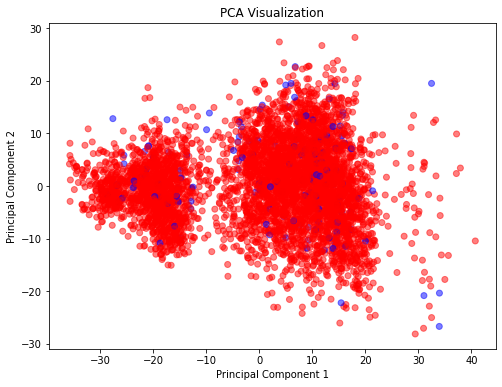

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce

# 初始化分类特征和数值特征列表
categorical_features = []
numerical_features = []

# 遍历DataFrame的每一列，判断数据类型并分别存储到对应的列表中
for col in X_train.columns:
    dtype = str(X_train[col].dtypes)
    dtype = dtype.split('[')[0]  # 移除括号后面的内容
    
    if dtype == "category":
        categorical_features.append(col)
    else:
        numerical_features.append(col)
        
# 填充数值特征中的缺失值为 0
X_train[numerical_features] = X_train[numerical_features].fillna(0)

# 对数据进行抽样，随机选择 5000 个数据
X_train_sampled = X_train.sample(n=5000, random_state=42)
y_train_sampled = y_train.sample(n=5000, random_state=42)

# 构建ColumnTransformer来处理混合类型的特征
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # 数值型特征进行标准化
        ('cat', ce.HashingEncoder(n_components=10), categorical_features)  # 字符串或对象类型的特征进行标签编码
    ])

# 构建PCA模型
pca = PCA(n_components=2)

# 构建Pipeline将数据预处理和PCA降维连接起来
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])


# 在数据上拟合Pipeline模型并进行降维
data_reduced = pipeline.fit_transform(X_train_sampled)

# 定义颜色映射，类别0对应红色，类别1对应蓝色
colors = ['r' if label == 0 else 'b' for label in y_train_sampled]

# 可视化降维后的数据
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.savefig("pca_visualization.png")
plt.show()


In [45]:
# 分析主成分占比

# 获取PCA模型的方差解释比例
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_

# 取前两个主成分的方差解释比例相加
variance_ratio_sum = variance_ratio[0] + variance_ratio[1]

# 输出 λ1+λ2 占全部λ之和的百分比
print(f"λ1+λ2 percentage：{variance_ratio_sum:.2%}")

λ1+λ2 percentage：71.80%
